In [23]:
%matplotlib inline
# Switch to ''%matplotlib ipympl' for interactive plots
import warnings
import imp
import pickle
import lmfit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

# Styling
warnings.filterwarnings("ignore")
plt.style.use('ggplot')

In [24]:
# Initialise wrapper and test datasets
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('..\..\Applications\Persist\persist.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [25]:
dataset = wr.DataSet.setup_from_parameter_and_input_files('..\..\Applications\Persist\Storelva\persist_params_Storelva.dat', '..\..\Applications\Persist\Storelva\persist_inputs_Storelva.dat')

In [26]:
comparisons = [
    ('Reach flow', ['Outlet'], 'Observed discharge outlet', [])
]

In [27]:
param_df = cu.get_double_parameters_as_dataframe(dataset)
param_df

,name,unit,index,min_value,initial_value,max_value
0,Snow multiplier,dimensionless,"(All,)",0.5000,1.000000,1.5
1,Snow melt temperature,°C,"(All,)",-4.0000,0.266117,4.0
2,Degree day melt factor,mm/°C/day,"(All,)",1.0000,1.058965,4.0
3,Rain multiplier,dimensionless,"(All,)",0.5000,1.000000,1.5
4,Initial snow depth,mm SWE,"(All,)",0.0000,0.000000,9999.0
5,Degree day evapotranspiration,mm/°C/day,"(All,)",0.0500,0.175222,0.2
6,Growing degree threshold,°C,"(All,)",-4.0000,-1.000000,4.0
7,Canopy interception,mm/day,"(All,)",0.0000,0.000000,0.3
8,Initial water depth,mm,"(Quick, All)",0.0000,0.000000,9999.0
9,Initial water depth,mm,"(Soilwater, All)",0.0000,300.000000,9999.0


In [28]:
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)


Goodness of fit for Reach flow [Outlet] vs Observed discharge outlet []:
Mean error (bias): 0.177815
Mean absolute error: 4.078528
Root mean square error: 7.794445
Nash-Sutcliffe coefficient: 0.743552
Number of observations: 3557



In [29]:
calib_df = param_df.loc[[1, 2, 5, 24, 25, 44, 45, 46, 75, 76]].reset_index(drop=True)
calib_df

,name,unit,index,min_value,initial_value,max_value
0,Snow melt temperature,°C,"(All,)",-4.000,0.266117,4.0
1,Degree day melt factor,mm/°C/day,"(All,)",1.000,1.058965,4.0
2,Degree day evapotranspiration,mm/°C/day,"(All,)",0.050,0.175222,0.2
3,Time constant,days,"(Soilwater, All)",1.000,1.930640,9999.0
4,Time constant,days,"(Groundwater, All)",1.000,116.825899,9999.0
5,a,1/m2,"(Vegår,)",0.001,0.014545,1.0
6,a,1/m2,"(Nes Verk,)",0.001,0.014545,1.0
7,a,1/m2,"(Outlet,)",0.001,0.014545,1.0
8,Percolation matrix,dimensionless,"(All, Soilwater, Soilwater)",0.000,0.796361,1.0
9,Percolation matrix,dimensionless,"(All, Soilwater, Groundwater)",0.000,0.203639,1.0


In [30]:
calib_df['short_name'] = [
    'T_melt',
    'DDfmelt',
    'DDfet',
    'T_s',
    'T_g',
    'a_V',
    'a_N',
    'a_O',
    'runoff_s',
    'baseflow_s',
]

params = cu.parameter_df_to_lmfit(calib_df)

params['baseflow_s'].set(expr = '1.0-runoff_s')
params['T_s'].min = 1.0
params['T_s'].max = 2.0
params['T_g'].min = 30.0
params['T_g'].max = 200.0
params['a_N'].set(expr = 'a_V')
params['a_O'].set(expr = 'a_V')


calib_df

,name,unit,index,min_value,initial_value,max_value,short_name
0,Snow melt temperature,°C,"(All,)",-4.000,0.266117,4.0,T_melt
1,Degree day melt factor,mm/°C/day,"(All,)",1.000,1.058965,4.0,DDfmelt
2,Degree day evapotranspiration,mm/°C/day,"(All,)",0.050,0.175222,0.2,DDfet
3,Time constant,days,"(Soilwater, All)",1.000,1.930640,9999.0,T_s
4,Time constant,days,"(Groundwater, All)",1.000,116.825899,9999.0,T_g
5,a,1/m2,"(Vegår,)",0.001,0.014545,1.0,a_V
6,a,1/m2,"(Nes Verk,)",0.001,0.014545,1.0,a_N
7,a,1/m2,"(Outlet,)",0.001,0.014545,1.0,a_O
8,Percolation matrix,dimensionless,"(All, Soilwater, Soilwater)",0.000,0.796361,1.0,runoff_s
9,Percolation matrix,dimensionless,"(All, Soilwater, Groundwater)",0.000,0.203639,1.0,baseflow_s


In [31]:
%%time
mi, res = cu.minimize_residuals(params, dataset, comparisons, method='nelder', norm=False, skip_timesteps=365)
print('Optimization results\n')
lmfit.report_fit(res)
print('\n\nOptimized parameter values:\n')
res.params.pretty_print(precision=3)

Optimization results

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 628
    # data points      = 3192
    # variables        = 7
    chi-square         = 144721.917
    reduced chi-square = 45.4385924
    Akaike info crit   = 12188.8192
    Bayesian info crit = 12231.2980
##  Warning: uncertainties could not be estimated:
[[Variables]]
    T_melt:      3.04386740 +/-        nan (nan%) (init = 0.2661174)
    DDfmelt:     3.88790110 +/-        nan (nan%) (init = 1.058965)
    DDfet:       0.16963901 +/- 0.00303103 (1.79%) (init = 0.1752219)
    T_s:         1.95739369 +/- 0.04775328 (2.44%) (init = 1.93064)
    T_g:         111.867418 +/- 36.4575488 (32.59%) (init = 116.8259)
    a_V:         0.01424263 +/- 4.1362e-04 (2.90%) (init = 0.01454498)
    a_N:         0.01424263 +/- 4.1686e-04 (2.93%) == 'a_V'
    a_O:         0.01424263 +/- 4.1686e-04 (2.93%) == 'a_V'
    runoff_s:    0.81545614 +/- 0.01287064 (1.58%) (init = 0.7963611)
    baseflow_s:  0.18


Goodness of fit for Reach flow [Outlet] vs Observed discharge outlet []:
Mean error (bias): 0.357416
Mean absolute error: 3.860507
Root mean square error: 7.347617
Nash-Sutcliffe coefficient: 0.772112
Number of observations: 3557



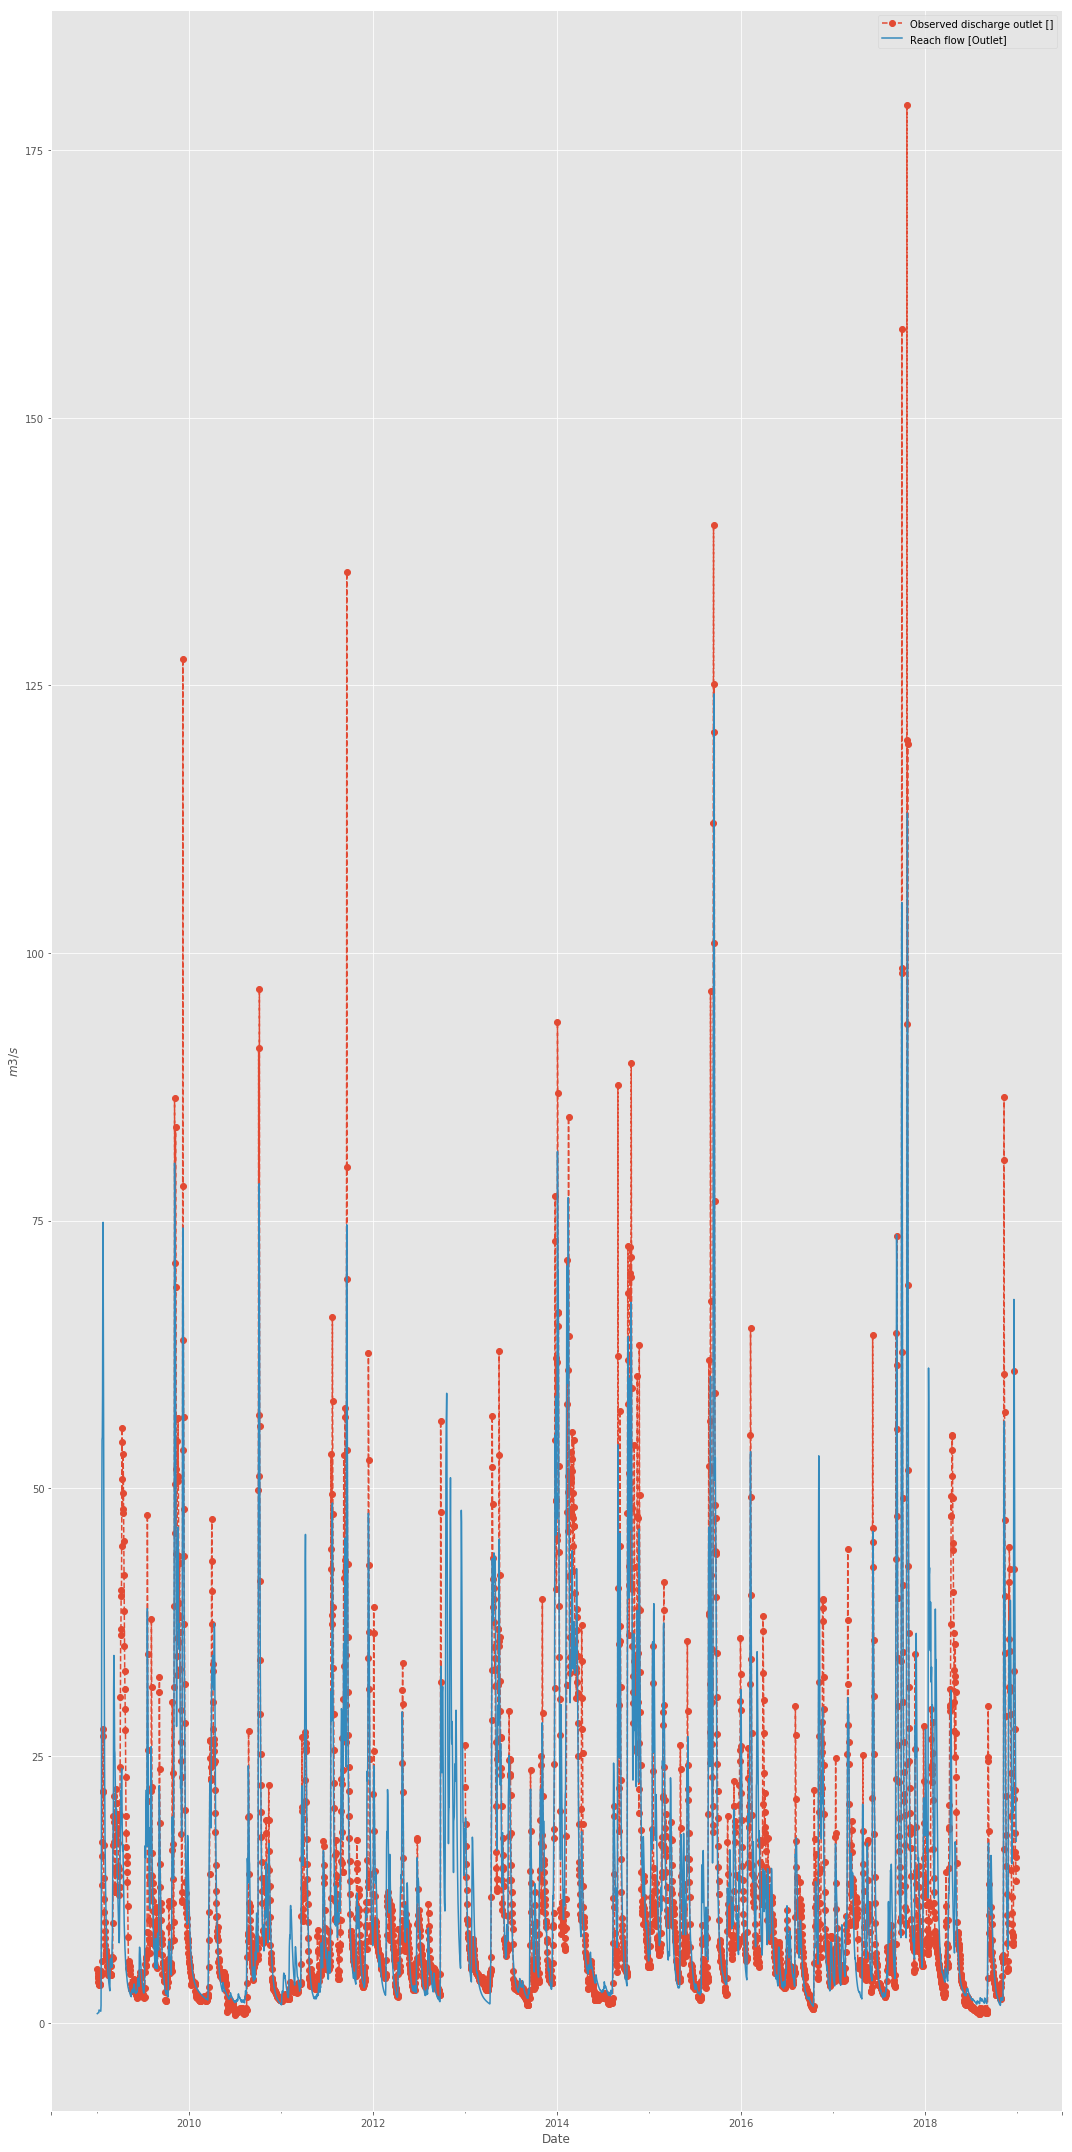

In [33]:
#print(res.params)
cu.set_parameter_values(res.params, dataset)
dataset.run_model()
cu.print_goodness_of_fit(dataset, comparisons)
cu.plot_objective(dataset, comparisons)

dataset.write_parameters_to_file('optimized_params.dat')

In [34]:
res.params.add('err_q', value = 0.5, min = 0.05, max = 3)

error_param_dict = {'Observed discharge outlet': 'err_q'}

res.params

name,value,standard error,relative error,initial value,min,max,vary,expression
T_melt,3.04386740,nan,nan%,0.26611739403944124,-4.00000000,4.00000000,True,
DDfmelt,3.88790110,nan,nan%,1.0589651882345101,1.00000000,4.00000000,True,
DDfet,0.16963901,0.00303103,1.79%,0.17522188919990514,0.05000000,0.20000000,True,
T_s,1.95739369,0.04775328,2.44%,1.9306404027402009,1.00000000,2.00000000,True,
T_g,111.867418,36.4575488,32.59%,116.825898686382,30.0000000,200.000000,True,
a_V,0.01424263,4.1362e-04,2.90%,0.014544980253344615,1.0000e-03,1.00000000,True,
a_N,0.01424263,4.1686e-04,2.93%,0.014544980253344615,1.0000e-03,1.00000000,False,a_V
a_O,0.01424263,4.1686e-04,2.93%,0.014544980253344615,1.0000e-03,1.00000000,False,a_V
runoff_s,0.81545614,0.01287064,1.58%,0.7963611445737504,0.00000000,1.00000000,True,
baseflow_s,0.18454386,0.01287669,6.98%,0.2036388554262496,0.00000000,1.00000000,False,1.0-runoff_s


In [36]:
nworkers = 8
ntemps   = 1
nsteps   = 10000
nwalk    = 100
nburn    = 1000
thin     = 1
init_chains = 'uniform'
skip_timesteps = 365
result_path = r'pickled\\mcmc_results.pkl'
chain_plot_path = r'plots\\chains.png'
corner_plot_path = r'plots\\corner.png'

settings_dict = {'params':res.params,
                 'error_param_dict':error_param_dict,
                 'comparisons':comparisons,
                 'skip_timesteps':skip_timesteps,
                 'nworkers':nworkers,
                 'ntemps':ntemps,
                 'nsteps':nsteps,
                 'nwalk':nwalk,
                 'nburn':nburn,
                 'thin':thin,
                 'init_chains':init_chains,
                 'result_path':result_path,
                 'chain_path':chain_plot_path,
                 'corner_path':corner_plot_path,                 
                }

with open('pickled\\mcmc_settings.pkl', 'wb') as handle:
    pickle.dump(settings_dict, handle)

In [ ]:
%run -i persist_calib_uncert.py

In [19]:
with open('pickled\\mcmc_results.pkl', 'rb') as handle:
    result = pickle.load(handle)
    
cu.set_parameter_values(result.params, dataset)
dataset.run_model()

dataset.write_parameters_to_file('mcmc_map_params.dat')

name,value,standard error,relative error,initial value,min,max,vary,expression
T_melt,3.08357897,0.40254668,13.05%,0.26611739403944146,-4.00000000,4.00000000,True,
DDfmelt,2.53160159,0.40152298,15.86%,1.0589651882345117,1.00000000,4.00000000,True,
DDfet,0.15871756,0.00674663,4.25%,0.17522188919990522,0.05000000,0.20000000,True,
T_s,1.94139057,0.24203071,12.47%,1.9306404027401958,1.00000000,2.00000000,True,
T_g,65.2519499,20.6129919,31.59%,116.82589868638237,30.0000000,200.000000,True,
a_V,0.01476719,0.11729281,794.28%,0.014544980253344619,1.0000e-03,1.00000000,True,
a_N,0.01476719,,,0.014544980253344619,1.0000e-03,1.00000000,False,a_V
a_O,0.01476719,,,0.014544980253344619,1.0000e-03,1.00000000,False,a_V
runoff_r,0.00183329,0.00705831,385.01%,0.002527784157330515,0.00000000,1.00000000,True,
baseflow_r,0.99816671,,,0.9974722158426694,0.00000000,1.00000000,False,1.0-runoff_r


In [18]:
highest_prob = np.argmax(result.lnprob)
hp_loc = np.unravel_index(highest_prob, result.lnprob.shape)
mle_soln = result.chain[hp_loc]
print(highest_prob)
print(mle_soln)

9430
[3.12397846e+00 2.55676429e+00 1.55611877e-01 1.99544266e+00
 6.87352323e+01 1.48753151e-02 1.15521800e-04 7.94123316e-01
 3.77625619e-01]



Goodness of fit for Reach flow [Outlet] vs Observed discharge outlet []:
Mean error (bias): 0.771484
Mean absolute error: 4.025048
Root mean square error: 7.508794
Nash-Sutcliffe coefficient: 0.762004
Number of observations: 3557



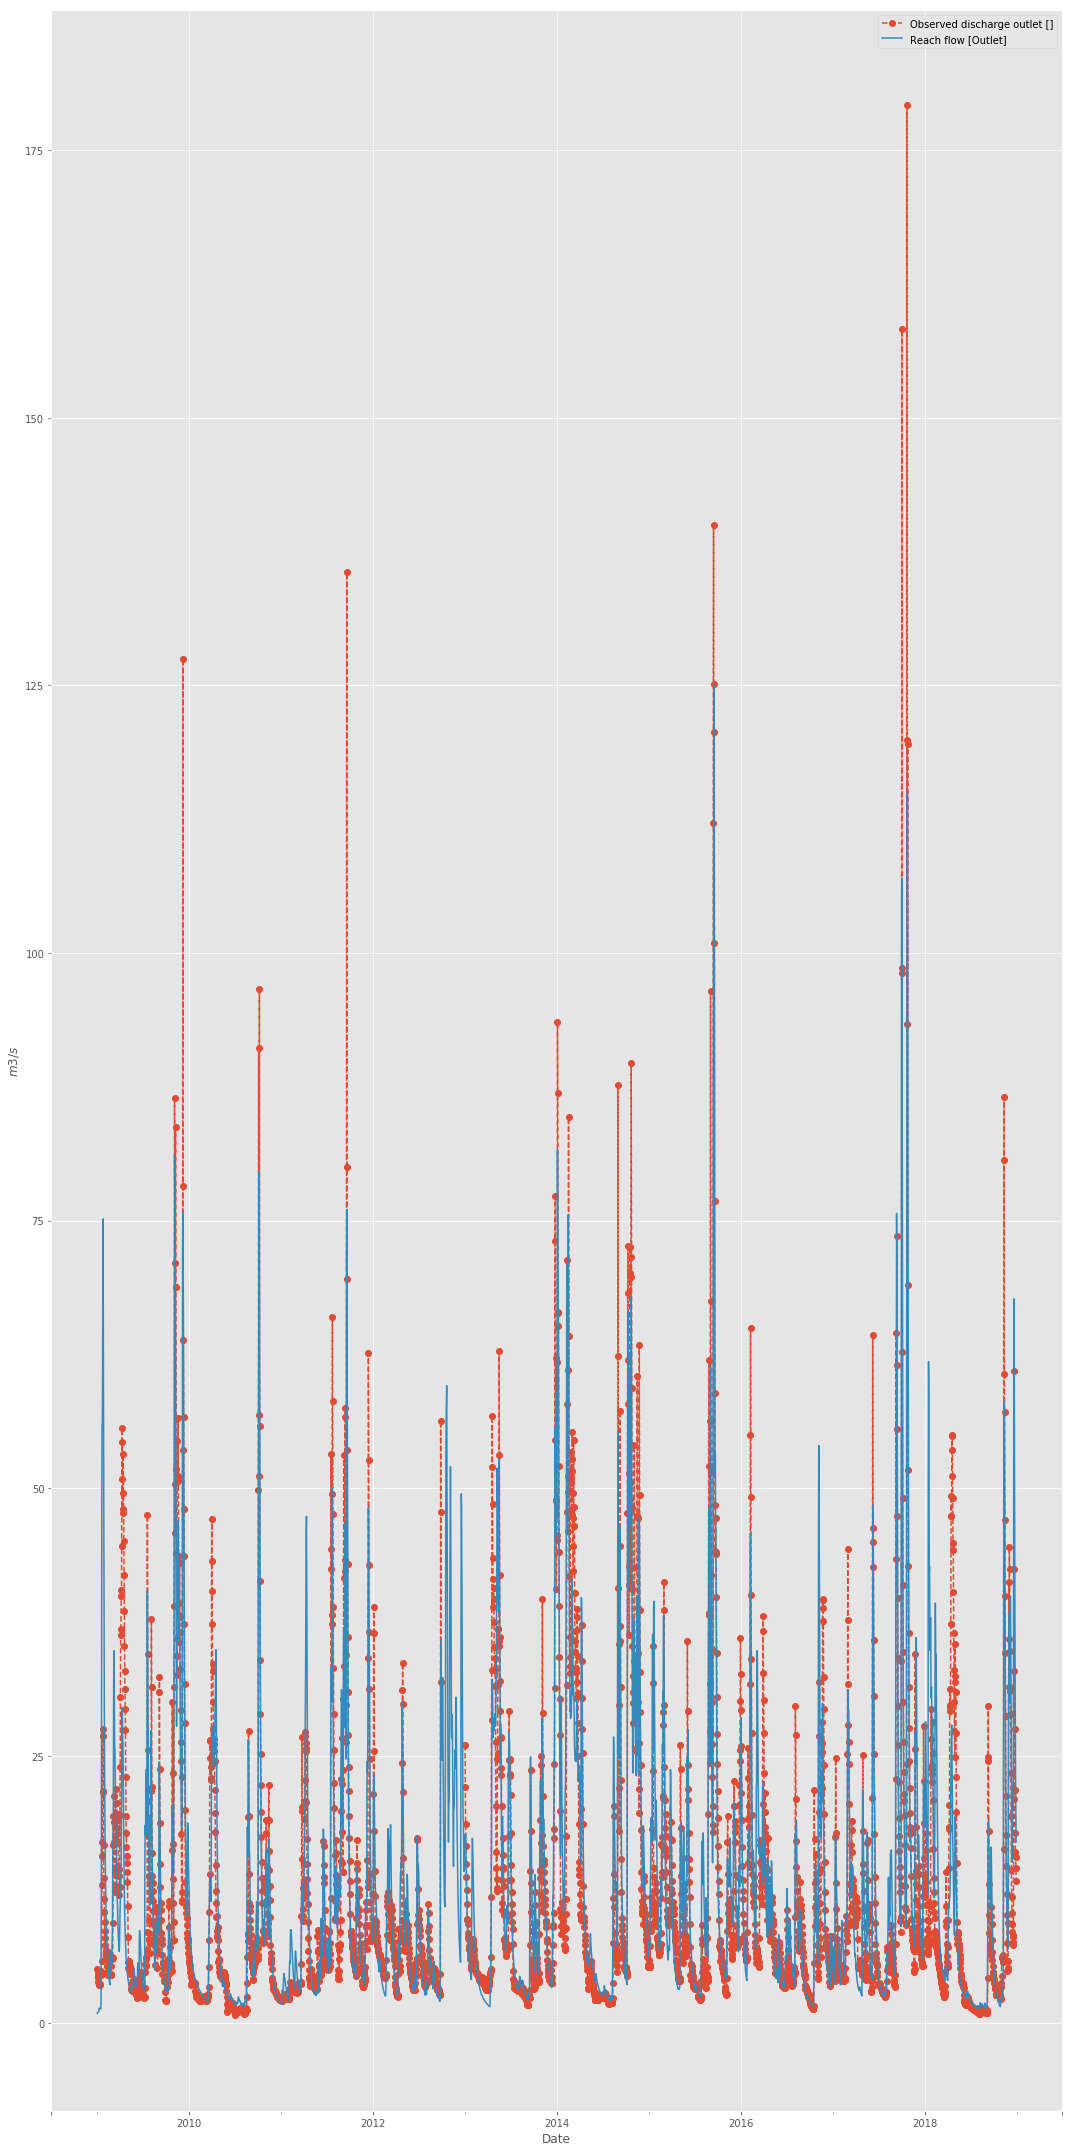

In [22]:
#par = result.params
#TODO: automate this! (we don't want to set the computed ones, but we need them to recompute based on what we set)
#par['T_melt'].set(value = mle_soln[0])
#par['DDfmelt'].set(value = mle_soln[1])
#par['DDfet'].set(value = mle_soln[2])
#par['T_s'].set(value = mle_soln[3])
#par['T_g'].set(value = mle_soln[4])
#par['a_V'].set(value = mle_soln[5])
#par['runoff_r'].set(value = mle_soln[6])
#par['runoff_s'].set(value = mle_soln[7])
#par['err_q']

#cu.set_parameter_values(par, dataset)
#dataset.run_model()
#cu.print_goodness_of_fit(dataset, comparisons)
#cu.plot_objective(dataset, comparisons)

#dataset.write_parameters_to_file('mcmc_map_params.dat')